<a href="https://colab.research.google.com/github/tiara567/Vehicle-Detection/blob/main/Turn_Image_Classifier_to_Object_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turn Image Classifier into Object Detector

0. Connect to drive. load the image classification model that has been made
1. Input Image 
2. Construct the sliding show
3. Construct Image Pyramid
4. Run sliding window at each scale of image pyramid
  *   each step of sliding window, extract ROI
  *   take ROI and passit to CNN image classifier
  *   set minimum probability, it it is passed record (class, label, box location
4. Apply Class wise NMS
5. Return Result

## Step 0: Load the image classifier model


1.   mount google colab to gdrive
2.   import classification model 



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
model = tf.keras.models.load_model("drive/My Drive/ImageClassificationEdited.h5") #load the model

## Step 1: Implementing image pyramid and sliding window utility functions

Define the function of:
* sliding_window (Detect exactly where in the image a given object is)
* image_pyramid (construct a multi-scale representation of an input image or Localize objects at different scales/sizes)




### sliding_window 

To Detect exactly where in the image a given object is
  * image = The input image that we are going to loop over and generate windows from. 
  * step =  Our step size, which indicates how many pixels we are going to “skip” in both the (x, y) directions.
  * ws= the window size defines the width and height (in pixels) of the window we are going to extract from our image. (The sliding green box)
  *   y= loop over our rows via determining a range of y-values
  *   x= loop over our columns (a range of x-values)
  *  *** how :*** ultimately yields the window of our image (i.e., ROI) according to the (x, y)-values, window size (ws), and step size.

In [3]:
# import the necessary packages
import imutils

#define the sliding_window function
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])



### image_pyramid 
**To construct a multi-scale representation of an input image or Localize objects at different scales/sizes**


*   image: The input image for which we wish to generate multi-scale representations.
*   scale: Our scale factor controls how much the image is resized at each layer. (Smaller scale values yield more layers in the pyramid)
*   minSize: Controls the minimum size of an output image (layer of our pyramid). (without defining minSize, infinite loop will be executed)
*   ***how:*** we go ahead and resize the image down to the width while maintaining aspect ratio 

In [4]:
#define the image_pyramid function
def image_pyramid(image, scale=1.5, minSize=(64, 64)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

## Import Necesary Packages

*   non_max_suppression: An implementation of NMS in my imutils package.
*   sliding_window: Our sliding window generator function as described in the previous section.
*   image_pyramid: The image pyramid generator that we defined previously.

In [5]:
# import the necessary packages
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import imutils
import time
import cv2
from google.colab.patches import cv2_imshow




*   --image: The path to the input image for classification-based object detection.
*   --size: A tuple describing the size of the sliding window. This tuple must be surrounded by quotes for our argument parser to grab it directly from the command line.
*   --min-conf: The minimum probability threshold to filter weak detections.
*   --visualize: A switch to determine whether to show additional visualizations for debugging.

## Initialize Used Paramater
* WIDTH: Given that the selection of images/ for testing have a consistent starting width, we know that the image will fit on our screen.
* PYR_SCALE: Our image pyramid scale factor. 
* WIN_STEP: Our sliding window step size, which indicates how many pixels we are going to “skip” in both the (x, y) directions. (smaller your step size is, the more windows you’ll need to examine)
* ROI_SIZE: Controls the aspect ratio of the objects we want to detect; if a mistake is made setting the aspect ratio, it will be nearly impossible to detect objects. 
* INPUT_SIZE: The classification CNN dimensions. 

In [6]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (32,16)
INPUT_SIZE = (64, 64)

## Load the input image 
* Load image from gdrive
* Resize it such that it has the supplied width
* Grab its dimensions
* show the input image

400 600


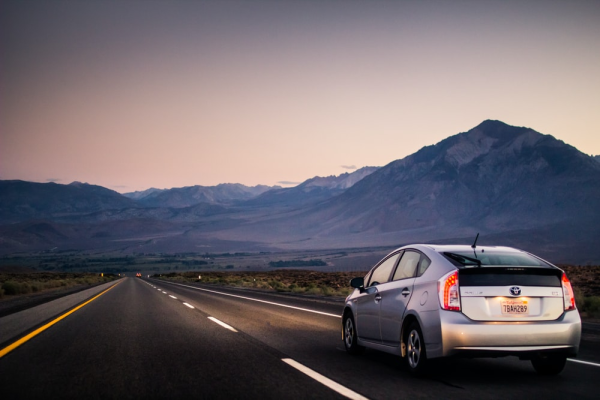

In [7]:
orig = cv2.imread("drive/My Drive/vehicle1.jpg")
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]
print(H,W)
cv2_imshow(orig)

## Supply the necessary parameters to image_pyramid function. 
*   rois: Holds the regions of interest (ROIs) generated from pyramid + sliding window output
*   locs: Stores the (x, y)-coordinates of where the ROI was in the original image
*   start timestamp so we can later determine how long our classification-based object detection method (given our parameters) took on the input image






In [8]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []


In [9]:
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])
	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)
		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)
		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

# show how long it took to loop over the image pyramid layers and sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end   = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))

[INFO] looping over pyramid/windows took 0.44020 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 4.57975 seconds


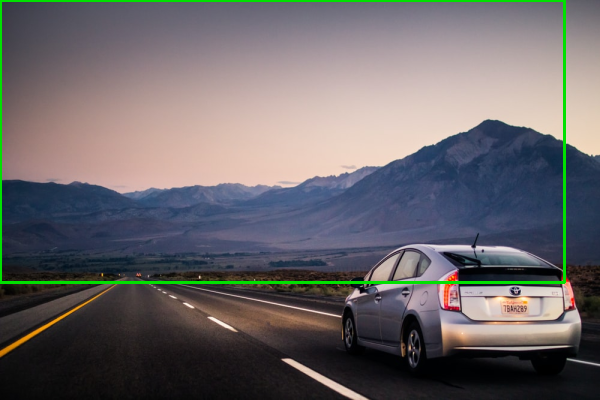

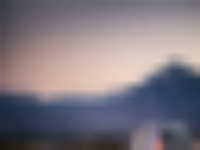

In [10]:
# HANDLE OPTIONAL VISUALIZATION
clone = orig.copy()
cv2.rectangle(clone, (x, y), (x + w, y + h),
  (0, 225, 0), 2)

# show the visualization and current ROI
cv2_imshow(clone)
roiOrig = cv2.resize(roiOrig, (200 ,150 ))
cv2_imshow(roiOrig)

In [11]:
prob = (len(preds))
if  prob >= 0.5:
  labels = "Vehicle"
else:
  labels = "Non-vehicle" 

In [12]:
print (labels)

Vehicle
